## Simulation-Based Inference: Type1a Supernovae
### Coverage Check
Created: March 26, 2023, for CLASHEP 2023, San Esteban, Chile, Harrison B. Prosper<br>

### Introduction 

This notebook checks the coverage of the confidence sets created in the notebook __02_phantom_inference.ipynb__ for a 2-parameter cosmological model fitted to the data from Type1a supernovae. (See phantom_model.ipynb for details.) The __frequentist principle__ requires that the coverage probability be bounded from below by the desired __confidence level__ (CL). In practice, if the coverage probability is within about 5 to 10\% of the desired CL that should be considered satisfactory.

### Coverage

  1. For each of 1000 randomly sampled parameter points $(n, H_0)$ taken from the 95\% confidence set computed for the real data, simulate 1000 Type 1a data sets, each consisting of data for 580 Type 1a supernovae, and compute the test statistic $\lambda_0$ for each simulated data set.
      1. Randomly pick a confidence level $\tau \in (0.5, 1)$ and compute the coverage probability; that is, compute the relative frequency $f$ with which the statement $\mathbb{P}(\lambda \le \lambda_0| n, H_0) \leq \tau$, or, equivalently, $n, H_0 \in R(D)$, is true over the ensemble of 1000 data sets, where $R(D)$ is the confidence set associated with data set $D$.
      1. Histogram the ratio $f \, / \, \tau$.
  1. If the simulation-based inference is valid, we expect the mean of the distribution $\mathbb{E}[f \, / \, \tau] \approx 1$ and its rms $=\sqrt{\mathbb{E}[(1 - f \, / \, \tau)^2]}$ to be small, say less than 5\%.

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# module to save results
import joblib as jb

# pytorch
import torch
import torch.nn as nn

# to reload modules
import importlib

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 16
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

In [3]:
%run phantom_model.ipynb

In [4]:
# read simulated Type1a data that mimick the real data for 580 supernova

datafile = 'data/type1a_simdata.csv.gz'
print('loading %s' % datafile)
tdata = pd.read_csv(datafile)

# get (unscaled) boundaries of parameter subspace 
xmin  = int(10*(tdata.n.min()+0.01))/10
xmax  = int(10*(tdata.n.max()+0.01))/10

ymin  = int(10*(tdata.H0.min()+0.01))/10
ymax  = int(10*(tdata.H0.max()+0.01))/10

# put everything into a bag called for convenience
class Bag:
    pass

bag = Bag()
bag.name   = 'phantom'

bag.weight = 'Z0'  # see hist_data
bag.xscale = 10    # scale by which to reduce "n" parameter
bag.xbins  = 10
bag.xmin   = xmin / bag.xscale
bag.xmax   = xmax / bag.xscale
bag.xstep  = 1    / bag.xscale
bag.xname  = 'n'
bag.xlabel = 'n'

bag.yscale = 100   # scale by which to reduce "H0" parameter
bag.ybins  = 10
bag.ymin   = ymin / bag.yscale
bag.ymax   = ymax / bag.yscale
bag.ystep  = 2    / bag.yscale
bag.yname  = 'H0'
bag.ylabel = 'H_0'

filename   = 'data/type1a_union2.1.txt'
bag.z, bag.x, bag.dx = read_data(filename)

# reduce the dynamic range of parameters n and H0
tdata.n   /= bag.xscale
tdata.H0  /= bag.yscale

features   = ['lo', 'n', 'H0']  # inputs into ML model
target     = 'Zo'               # targets for ML model

print()
print('number of rows:', len(tdata))
print(f'xmin: {bag.xmin:4.2f}, xmax: {bag.xmax:4.2f}')
print(f'ymin: {bag.ymin:4.2f}, ymax: {bag.ymax:4.2f}')

tdata[:5]

loading data/type1a_simdata.csv.gz
number of observations: 580
     	         z	         x +/- dx        
    0	     0.028	   35.3466 +/- 0.2239    
  100	     0.065	   37.3067 +/- 0.1628    
  200	     0.194	   39.9615 +/- 0.1264    
  300	     0.620	   43.2280 +/- 0.3903    
  400	     0.710	   43.0220 +/- 0.1843    
  500	     0.564	   42.3729 +/- 0.2920    

number of rows: 125000
xmin: 0.05, xmax: 0.60
ymin: 0.66, ymax: 0.76


,n,H0,l,l0,lo,Z0,Zo
0,0.335650,0.693135,1.024721,1.069084,1.001841,1,0
1,0.481360,0.717442,1.016954,1.116854,0.966655,1,0
2,0.187341,0.661942,1.017248,1.092019,1.011932,1,0
3,0.435773,0.753917,1.019675,1.086881,0.991170,1,0
4,0.188308,0.754367,1.009683,1.606686,1.004998,1,0


### Load 95\% Confidence Set

A confidence set at confidence level (CL) $100 \times \tau$\% is the set of 
 all parameter points $(n, H_0)$ for which
$$\mathbb{P}(\lambda \le \lambda_0 | n, H_0) \le \tau,$$

where $\lambda_0$ is the observed value of the test statistic for a given point $(n, H_0)$. Since $\lambda_0$ depends both on the data ($D$), which are *fixed*, as well as on the parameters $\theta \equiv (n, H_0)$, in general, $\lambda_0(D, \theta)$ will vary from one parameter point to the next.

The 95\% CL confidence set pertains to the Union 2.1 supernovae data.

In [5]:
# read 95% confidence set
bag.CL = 0.95
c95    = pd.read_csv('data/type1a_95CL.csv')
n      = c95.n.to_numpy()
H0     = c95.H0.to_numpy()
c95[:10]

,n,H0
0,0.224555,0.700893
1,0.268223,0.707235
2,0.187647,0.691416
3,0.273057,0.715483
4,0.384381,0.738267
5,0.200567,0.677708
6,0.218639,0.683929
7,0.197785,0.697138
8,0.376473,0.728972
9,0.441521,0.742820


### Load trained ML model

Load the model that approximates $\mathbb{P}(\lambda < \lambda_0| n, H_0)$.

In [6]:
import phantom_dnn as NN
importlib.reload(NN)

def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

name     = NN.name
model    = NN.model
features = NN.features
target   = NN.target

Load_model = False
modelfile  = '%s.dict' % NN.name
print('load model: %s' % modelfile)

modeldict = torch.load(modelfile)
NN.model.load_state_dict(modeldict)

print(name)
print(model)
print('number of parameters: %d' % number_of_parameters(model))

load model: phantom.dict
phantom
Sequential(
  (0): Linear(in_features=3, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=40, bias=True)
  (3): ReLU()
  (4): Linear(in_features=40, out_features=40, bias=True)
  (5): ReLU()
  (6): Linear(in_features=40, out_features=40, bias=True)
  (7): ReLU()
  (8): Linear(in_features=40, out_features=1, bias=True)
  (9): Sigmoid()
)
number of parameters: 5121


### Place a simple wrapper around the ML model for convenience

In [7]:
def cdf(l, n, H, f=model):   
    # go to evaluation mode
    model.eval()
    
    # compute,reshape to a 1d array, and convert to a numpy array
    X = torch.Tensor(np.array([l, n, H]).T)
    Y = model(X).view(-1,).detach().numpy()
    if len(Y) == 1:
        return Y[0]
    else:
        return Y

In [8]:
def plot_confidence_set(x, y, d, filename='phantom_95CL_set.png', 
                        fgsize=(5, 5), ftsize=14):
        
    xbins, xmin, xmax, xstep = d.xbins, d.xmin, d.xmax, d.xstep
    ybins, ymin, ymax, ystep = d.ybins, d.ymin, d.ymax, d.ystep

    # Now make plots
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$%s$' % d.xlabel, fontsize=ftsize)
    ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(r'$%s$' % d.ylabel, fontsize=ftsize)

    ax.scatter(x, y, s=1, c='steelblue')

    xpos = xmin + 0.1*(xmax-xmin)
    ypos = ymin + 0.9*(ymax-ymin)
    percent = '%'
    CL   = int(100*d.CL)
    ax.text(xpos, ypos, f'{CL:2d}\% CL set', fontsize=ftsize)
        
    ax.grid()

    plt.tight_layout()

    print('saved to file:', filename)
    plt.savefig(filename)
        
    plt.show()

saved to file: phantom_95CL_set.png


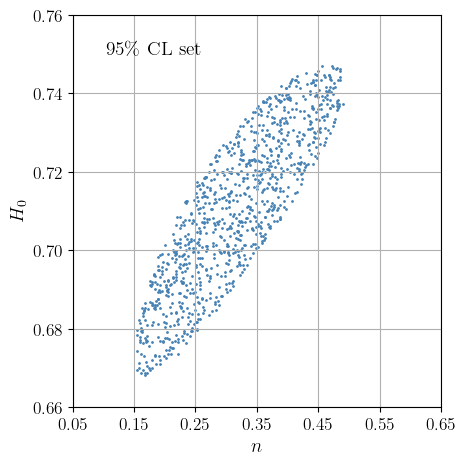

In [16]:
N = 1000 # number of parameter points to use for coverage check
plot_confidence_set(n[:N], H0[:N], bag, 
                    filename='phantom_%2.2dCL_set.png' % int(100*bag.CL))

### Check Coverage Probability 

For a given *fixed* point $(n, H_0)$, simulate 1000 instances of 580 Type 1a data. For each data instance, $D$, compute the test statistic $\lambda_0 \equiv \lambda(D, n, H_0)$. By definition, if $\mathbb{P}(\lambda \le \lambda_0 | n, H_0) \le \tau$, where $\tau$ is the desired confidence level the point $(n, H_0)$ lies within the confidence set associated with $D$. The coverage probability, $f$, is simply the fraction of data instances for which this statement is true. If our neural network approximation of the cdf $\mathbb{P}(\lambda \le \lambda_0 | n, H_0)$ is accurate, then we expect $p \approx \tau$.

In [10]:
def simulate_test_statistics(n, H0, d, size=1000):
    
    # numpy array for test statistics
    l = np.zeros(size)
    
    for i in range(size):
        
        # compute distance moduli for given parameter point (n, H0)
        mu= distance_modulus(d.z, n, H0)
        
        # generate data
        x = np.random.normal(loc=mu, scale=d.dx)
        
        # compute test statistic
        y = (x - mu)/d.dx 
        l[i] = (y**2).mean()
        
    l = np.sqrt(l)
    if size < 2:
        return l[0]
    else:
        return l

In [17]:
statistics = []
print(f'number of parameter points: {N:d}')
for i, x, y in zip(range(N), n, H0):
    statistics.append( simulate_test_statistics(x, y, bag) )
    if i % 10 == 0:
        print(f'\r{i:5d}', end='')
print()
print('done!')

number of parameter points: 1000
  990
done!


In [18]:
def compute_coverage(cdf, l, n, H0, cov, ecov, tau, x1, x2):
    # N: number of parameter points
    # K: number of data instances / parameter point
    N, K = l.shape
    t = list(np.random.uniform(0.5, 1.0, N))
    c = [0] * N
    e = [0] * N
    for j, x, y in zip(range(N), n, H0):
        x = np.full((K), x)
        y = np.full((K), y)
        p = cdf(l[j], x, y)
    
        c[j] = np.mean(p <= t[j])
        e[j] = np.sqrt(c[j]*(1 - c[j])/K)
        x    = c[j] / t[j]
        x1  += x
        x2  += x*x
        
    cov  += c
    ecov += e
    tau  += t
    return cov, ecov, tau, x1, x2

For each point $(n, H_0)$ randomly select 10 confidence levels, $\tau$, for which to check the coverage.

In [19]:
l   = np.array(statistics)
cov = []
ecov= []
tau = []
x1  = 0
x2  = 0
for k in range(10):
    r = compute_coverage(cdf, l, n, H0, cov, ecov, tau, x1, x2)
    cov, ecov, tau, x1, x2 = r
    print(f'\r{k:5d}', end='')
    
M   = len(cov)
x1 /= M
x2 /= M
x2  = np.sqrt(x2-x1*x1)
f   = 100 * x2 / x1

print()
print('cov/tau: %6.3f (%4.1f%s)' % (x1, f, '%'))
print('\ndone!')

    9
cov/tau:  1.000 ( 2.2%)

done!


In [26]:
def plot_actual_coverage(x, y, tau, cov, d, N=1000, M=4000,
                         filename='type1a_coverage.png', 
                         fgsize=(12, 4), ftsize=20):

        
    fig, axx = plt.subplots(nrows=1, ncols=3, figsize=fgsize)
    
    # plot points in coverage set that have been used.
    ax = axx[0]
    xmin, xmax = d.xmin, d.xmax
    ymin, ymax = d.ymin, d.ymax

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(r'$%s$' % d.xlabel, fontsize=ftsize)
    ax.set_ylabel(r'$%s$' % d.ylabel, fontsize=ftsize)
    ax.scatter(x[:N], y[:N], 
               s=1, c='steelblue', #alpha=0.7, 
               label='95\% CL set')
    ax.legend(fontsize=14)
    ax.grid()

    # plot coverage versus tau
    ax = axx[1]
    ax.set_xlim(0.5, 1)
    ax.set_ylim(0.5, 1)
    ax.set_xlabel(r'$\tau$', fontsize=ftsize)
    ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_ylabel(r'coverage', fontsize=ftsize)
    ax.scatter(tau[:M], cov[:M], 
               s=1, c='steelblue')
    
    ax.plot([0.5, 1], [0.5, 1], linewidth=3, c='yellow')
    ax.grid()
    
    # histogram coverage / tau
    ax = axx[2]
    xmin = 0.6
    xmax = 1.4
    xbins=100
    ax.set_xlim(xmin, xmax)
    #ax.set_xticks([0.8, 0.9, 1.0, 1.1, 1.2])
    ax.set_xlabel(r'$\textrm{coverage} \, / \, \tau$', 
                  fontsize=ftsize) 
    cov = np.array(cov)
    tau = np.array(tau)
    y   = cov / tau
    mean= y.mean()
    rms = np.sqrt(((1 - y)**2).mean())
    
    h   = ax.hist(y, bins=xbins, range=(xmin, xmax),
            color='steelblue',
            alpha=0.7)
    
    ymin= 0
    ii  = int(h[0].max()/500)
    ymax= (ii+1)*500
    ax.set_ylim(ymin, ymax)
        
    xpos = xmin + 0.55*(xmax-xmin)
    ypos = ymin + 0.80*(ymax-ymin)
    ystep= (ymax-ymin)/10
    
    ax.text(xpos, ypos, 'mean: %6.3f' % mean)
    
    ypos -= ystep
    ax.text(xpos, ypos, ' rms: %6.3f' % rms)
    
    ax.grid()
    
    plt.tight_layout()
    print(gfile)
    plt.savefig(gfile)
    plt.show()

type1a_coverage.png


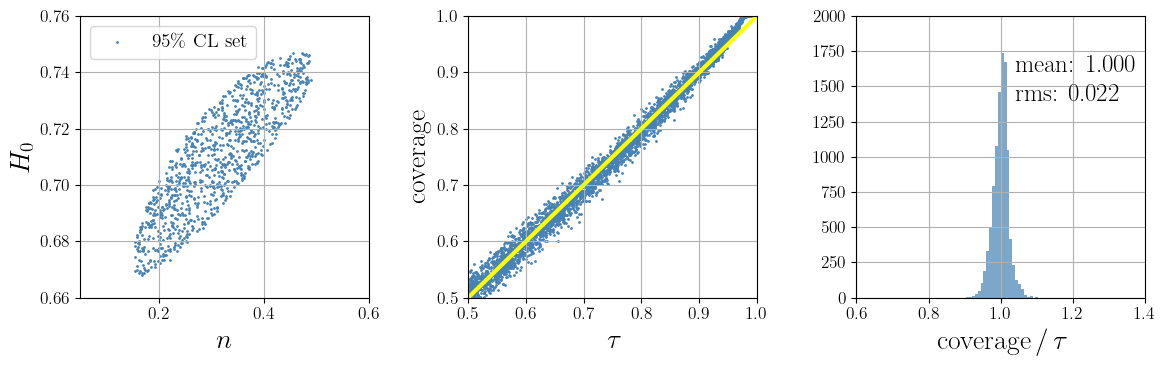

In [27]:
gfile = 'type1a_coverage.png'
plot_actual_coverage(n, H0, tau, cov, bag, filename=gfile)